# Transformer : Character-level Name Translation

In this homework, you will create an MT : Machine Translation model that coverts names from Thai  to English

For example
 - นิยม    ---> niyom
 - สมชาย  ---> chomchai

# (1) Install libraries

In [5]:
# pythainlp
!pip install pythainlp==5.0.2
# trainer
!cd /content/drive/MyDrive/pytorch-trainer && git checkout ai4eng2020 && pip install .

# transformers
!pip install transformers==4.40.0

M	trainer/average.py
M	trainer/seed.py
M	trainer/types.py
HEAD is now at 06fc72b fix validation cb
Processing /content/drive/MyDrive/pytorch-trainer
  Preparing metadata (setup.py) ... done
  Created wheel for trainer: filename=trainer-0.1-py3-none-any.whl size=37116 sha256=e9f67dac9ce4f8fe110b794240bcf0c8d832241e0df445e59588df71605d095c
  Stored in directory: /root/.cache/pip/wheels/39/8e/49/285e7805966272b24753ba04e88a10741a36b7dbbaba4c0f63
Successfully built trainer


In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as F

# (2) Our Dataset

In [7]:
!wget https://raw.githubusercontent.com/Sorananakiii/Thai-News-Topic-Classification/master/name_datasets.csv

--2025-04-24 03:58:08--  https://raw.githubusercontent.com/Sorananakiii/Thai-News-Topic-Classification/master/name_datasets.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 258960 (253K) [text/plain]
Saving to: ‘name_datasets.csv’

name_datasets.csv   100%[===================>] 252.89K  --.-KB/s    in 0.01s   

2025-04-24 03:58:08 (19.9 MB/s) - ‘name_datasets.csv’ saved [258960/258960]



In [8]:
df = pd.read_csv('name_datasets.csv')

# Overview Our data
df.head()

,TH_name,ENG_name
0,ไกรสีห์,kraisi
1,พัชรี,phatri
2,ธีระ,thira
3,วุฒิกร,wutthikon
4,ไสว,sawai


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8999 entries, 0 to 8998
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   TH_name   8999 non-null   object
 1   ENG_name  8999 non-null   object
dtypes: object(2)
memory usage: 140.7+ KB


## Distribution of name lengths

minimum thai name length :  2
maximum thai name length :  20


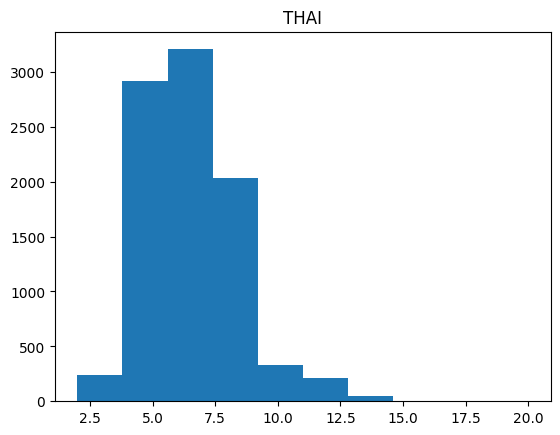

In [10]:
print('minimum thai name length : ', df['TH_name'].apply(len).min())
print('maximum thai name length : ',df['TH_name'].apply(len).max())
plt.title('THAI')
plt.hist(df['TH_name'].apply(len));

minimum eng name length :  2
maximum eng name length :  19


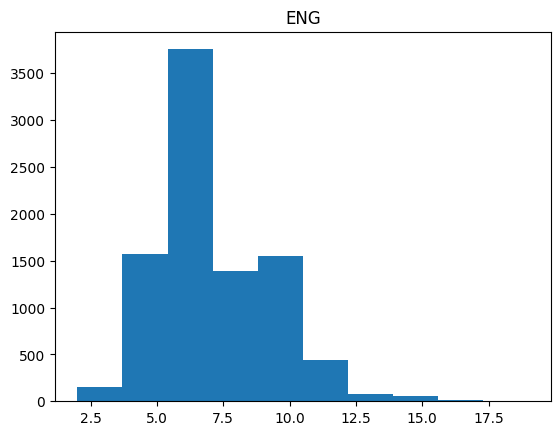

In [11]:
print('minimum eng name length : ', df['ENG_name'].apply(len).min())
print('maximum eng name length : ',df['ENG_name'].apply(len).max())
plt.title('ENG')
plt.hist(df['ENG_name'].apply(len));

# (3) Split train-Validation-test Dataset

In [12]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=1000, random_state=0)
df_train, df_val = train_test_split(df_train, test_size=1000, random_state=0)

In [13]:
print('train:', len(df_train))
print('val:', len(df_val))
print('test:', len(df_test))

train: 6999
val: 1000
test: 1000


# (4) Create pytorch datasets

Generally, there are two kinds of datasets:

- Word-level
- Character-level

We will do **character-level**.

### We will transform each character into an integer

### Input

```
thai name ids: [0, 32, 37, 37, 21, 37, 22, 51, 1]
thai name: พรรณรดา
```

### Output

```
eng name ids: [0, 18, 23, 16, 20, 3, 6, 3, 1]
eng name: punrada
```

`0` = begin of sentence token (BOS)

`1` = end of sentence token (EOS)

**We have each dictionary for each language**

### All the characters we would use in each dictionary

In [14]:
import pythainlp as thai
import string

extras = '.-() !?'
th_chars = list(thai.thai_characters + extras)
en_chars = list(string.ascii_lowercase + extras)

print('th:', th_chars)
print('en:', en_chars)

th: ['ก', 'ข', 'ฃ', 'ค', 'ฅ', 'ฆ', 'ง', 'จ', 'ฉ', 'ช', 'ซ', 'ฌ', 'ญ', 'ฎ', 'ฏ', 'ฐ', 'ฑ', 'ฒ', 'ณ', 'ด', 'ต', 'ถ', 'ท', 'ธ', 'น', 'บ', 'ป', 'ผ', 'ฝ', 'พ', 'ฟ', 'ภ', 'ม', 'ย', 'ร', 'ล', 'ว', 'ศ', 'ษ', 'ส', 'ห', 'ฬ', 'อ', 'ฮ', 'ฤ', 'ฦ', 'ะ', 'ั', 'า', 'ำ', 'ิ', 'ี', 'ึ', 'ื', 'ุ', 'ู', 'เ', 'แ', 'โ', 'ใ', 'ไ', 'ๅ', 'ํ', '็', '่', '้', '๊', '๋', 'ฯ', 'ฺ', 'ๆ', '์', 'ํ', '๎', '๏', '๚', '๛', '๐', '๑', '๒', '๓', '๔', '๕', '๖', '๗', '๘', '๙', '฿', '.', '-', '(', ')', ' ', '!', '?']
en: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '.', '-', '(', ')', ' ', '!', '?']


### Tokenizer

Tokenizer = converter between sentence <==> ints

It also holds the dictionary.

In [15]:
from torch.utils.data import Dataset

class Tokenizer:
    def __init__(self, characters, bos_token='<s>', eos_token='</s>', pad_token='<pad>'):
        self.special_tokens = [bos_token, eos_token, pad_token]
        self.i_to_c = self.special_tokens + list(characters)
        self.c_to_i = {c: i for i, c in enumerate(self.i_to_c)}

        self.bos_token_id = self.c_to_i[bos_token]
        self.eos_token_id = self.c_to_i[eos_token]
        self.pad_token_id = self.c_to_i[pad_token]
        self.special_token_ids = [self.bos_token_id, self.eos_token_id, self.pad_token_id]

    def __len__(self):
        return len(self.i_to_c)

    def encode(self, string):
        """encode a string into a list of ints, with sandwiched by <bos> and <eos>"""
        return [self.bos_token_id] + [self.c_to_i[c] for c in string] + [self.eos_token_id]

    def pad_encoded_batch(self, list_of_ids):
        """pad different lengths with <pad> to have the same length"""
        max_len = max(len(ids) for ids in list_of_ids)
        for ids in list_of_ids:
            n_pad = max_len - len(ids)
            if n_pad > 0:
                ids.extend([self.pad_token_id] * n_pad)
        return list_of_ids

    def decode(self, ids, skip_special_tokens=False):
        """decode a list of ints into a string"""
        out = []
        for i in ids:
            if skip_special_tokens and i in self.special_token_ids:
                continue
            out.append(self.i_to_c[i])
        out = ''.join(out)
        return out

    def decode_batch(self, list_of_ids, skip_special_tokens=False):
        """decode a list of list of ints into a list of strings"""
        out = []
        for ids in list_of_ids:
            out.append(self.decode(ids, skip_special_tokens=skip_special_tokens))
        return out

class ParallelNameDataset(Dataset):
    """the dataset"""
    def __init__(self, df, tokenizer_th, tokenizer_en):
        self.df = df
        self.tokenizer_th = tokenizer_th
        self.tokenizer_en = tokenizer_en

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        """returns a tuple of (th, eng) names"""
        a, b = self.df.iloc[i]
        a = self.tokenizer_th.encode(a)
        b = self.tokenizer_en.encode(b)
        return a, b

In [16]:
print('Thai Name Legnth : [{}, {}]'.format(df.TH_name.apply(len).min(), df.TH_name.apply(len).max()))
print('English Name Legnth : [{}, {}]'.format(df.ENG_name.apply(len).min(), df.ENG_name.apply(len).max()))

Thai Name Legnth : [2, 20]
English Name Legnth : [2, 19]


In [17]:
# Define Out Data
max_len = max(df.TH_name.apply(len).max(), df.ENG_name.apply(len).max())

tokenizer_th = Tokenizer(th_chars)
tokenizer_en = Tokenizer(en_chars)

train_data = ParallelNameDataset(df_train, tokenizer_th, tokenizer_en)
val_data = ParallelNameDataset(df_val, tokenizer_th, tokenizer_en)
test_data = ParallelNameDataset(df_test, tokenizer_th, tokenizer_en)

In [18]:
x, y = train_data[0]
print('thai name ids:', x)
print('thai name:', tokenizer_th.decode(x, skip_special_tokens=True))
print('eng name ids:', y)
print('eng name:', tokenizer_en.decode(y, skip_special_tokens=True))

thai name ids: [0, 25, 39, 54, 1]
thai name: ทวี
eng name ids: [0, 22, 10, 3, 25, 11, 1]
eng name: thawi


## How to load in batches?

Each name has a different length. How to "batch" them together?

Let's say we have 2 names with lengths 8, 10.

The batch will have the shape `[2, 10]`

- 2 = batch size
- 10 = maximum length of the two

In [19]:
import torch
from torch.utils.data import DataLoader

class Collator:
    def __init__(self, tokenizer_th, tokenizer_en):
        self.tokenizer_th = tokenizer_th
        self.tokenizer_en = tokenizer_en

    def __call__(self, list_of_xy):
        """input is a list of (th, eng)"""
        X, Y = [], []
        for x, y in list_of_xy:
            X.append(x)
            Y.append(y)
        # make the names to be of equal lengtsh
        X = self.tokenizer_th.pad_encoded_batch(X)
        Y = self.tokenizer_en.pad_encoded_batch(Y)
        # convert to tensor
        X = torch.LongTensor(X)
        Y = torch.LongTensor(Y)
        return X, Y

In [20]:
loader = DataLoader(train_data,
                    batch_size=2,
                    shuffle=False,
                    collate_fn=Collator(tokenizer_th, tokenizer_en),
)
itr = iter(loader)

In [21]:
# Converting back ids to string
x, y = next(itr)
print('x:', x)
print('decoded:', tokenizer_th.decode_batch(x, skip_special_tokens=True))
print('y:', y)
print('decoded:', tokenizer_en.decode_batch(y, skip_special_tokens=True))

x: tensor([[ 0, 25, 39, 54,  1,  2,  2,  2,  2],
        [ 0, 42, 57, 39, 53, 25, 36, 74,  1]])
decoded: ['ทวี', 'สุวิทย์']
y: tensor([[ 0, 22, 10,  3, 25, 11,  1],
        [ 0, 21, 23, 25, 11, 22,  1]])
decoded: ['thawi', 'suwit']


# (5) Transformer model
paper : https://arxiv.org/pdf/1706.03762.pdf

<img src="https://miro.medium.com/max/565/1*v1fprGL_4mBvCMi02UuhRQ.png" style="width: 720px;"/>


## Positional encoding

Every transformer model requires a "positional encoding". Here we used to "sinusoid" encoding.

In [22]:
import math

class SinPositionalEncoding(nn.Module):
    """
    taken from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """
    def __init__(self, d_model, max_len):
        super().__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() *
            (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

They are alternating between sin and cos of different frequencies.

The model uses this knowledge to learn specfic functions on different locations of an input.

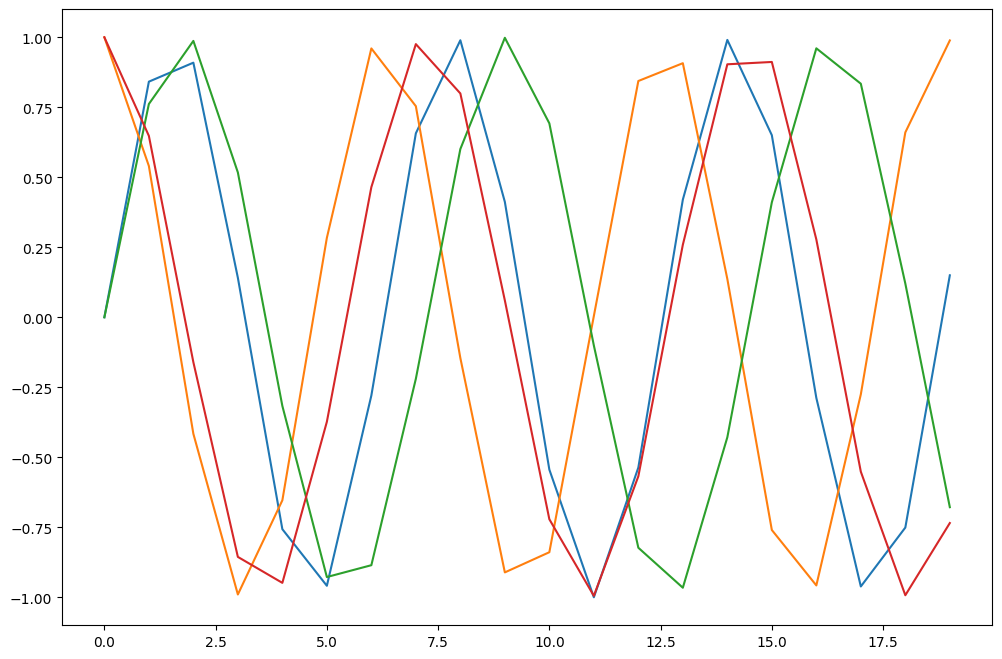

In [23]:
pos_emb = SinPositionalEncoding(d_model=128, max_len=max_len)
# example input (t, n, dim)
x = torch.zeros(max_len, 1, 128)
x = pos_emb(x)
# plot the first few dims
plt.figure(figsize=(12,8))
for i in range(4):
    plt.plot(range(max_len), x[:, 0, i])

In [24]:
# from trainer.start import *
from transformers.modeling_outputs import ModelOutput, dataclass
from transformers import PreTrainedModel, PretrainedConfig

In [25]:
# Config
@dataclass
class Config:
    vocab_size_enc: int
    vocab_size_dec: int
    max_len: int
    pad_token_id_enc: int
    pad_token_id_dec: int
    n_hid: int
    n_head: int
    n_ff: int
    dropout: float
    n_layer: int

    @property
    def name(self):
        name = f'{self.n_hid}hid-{self.n_head}head-{self.n_ff}ff-{self.dropout}drop-{self.n_layer}layer'
        return name

In [26]:
conf = Config(vocab_size_enc=len(tokenizer_th),
              vocab_size_dec=len(tokenizer_en),
              max_len=max_len,
              pad_token_id_enc=tokenizer_th.pad_token_id,
              pad_token_id_dec=tokenizer_en.pad_token_id,
              n_hid=128,
              n_head=4,
              n_ff=128*4,
              dropout=0,
              n_layer=2,
)

print(conf.name)

128hid-4head-512ff-0drop-2layer


## Encoder

In [27]:
class NameEncoder(nn.Module):
    def __init__(self, conf: Config):
        super().__init__()
        self.conf = conf
        self.pos_emb = SinPositionalEncoding(conf.n_hid, max_len=conf.max_len)
        self.emb = nn.Embedding(conf.vocab_size_enc, conf.n_hid)
        self.enc = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                conf.n_hid,
                conf.n_head,
                conf.n_ff,
                conf.dropout,
            ),
            num_layers=conf.n_layer,
        )

    def forward(self, input_ids, **kwargs):
        """
        Args:
            input_ids: long tensor (n, t) of the name
        """
        # (n, t)
        n, max_t = input_ids.shape
        # masking the padded locations
        # (n, t)
        enc_pad_mask = input_ids == self.conf.pad_token_id_enc

        # convert to (t, n)
        xt = input_ids.permute([1, 0])
        # ids => vector
        xt = self.emb(xt)
        # including the positional encoding (sin, cos)
        xt = self.pos_emb(xt)
        # put to the transformer layers
        # (t, n, n_hid)
        enc_out = self.enc.forward(src=xt, src_key_padding_mask=enc_pad_mask)
        # convert back to (n, t, n_hid)
        enc_out = enc_out.permute([1, 0, 2])
        return {
            'last_hidden_state': enc_out,
            'pad_mask': enc_pad_mask,
        }

In [28]:
enc = NameEncoder(conf)

x, y = next(itr)
print('x:', x.shape)
enc_out = enc.forward(x)
print('last hidden state:', enc_out['last_hidden_state'].shape)
print('out pad mask:', enc_out['pad_mask'].shape)

x: torch.Size([2, 12])
last hidden state: torch.Size([2, 12, 128])
out pad mask: torch.Size([2, 12])


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


## Decoder

We make use of [Huggingface's Transformer](https://huggingface.co/transformers/) library to simplify our code.

The lines with `#required by Huggingface` is not that important to understand in details.

In [29]:
# required by Huggingface
@dataclass
class DecoderOutput(ModelOutput):
    """output of the decoder needed by Huggingface library"""
    loss: torch.Tensor = None
    logits: torch.Tensor = None

class NameDecoder(PreTrainedModel):
    def __init__(self, conf: Config):
        # required by Huggingface
        base_config = PretrainedConfig()
        base_config.vocab_size = conf.vocab_size_dec
        super().__init__(base_config)
        # our model
        self.conf = conf
        self.pos_emb = SinPositionalEncoding(conf.n_hid, max_len=conf.max_len)
        self.emb = nn.Embedding(conf.vocab_size_dec, conf.n_hid)
        self.dec = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(
                conf.n_hid,
                conf.n_head,
                conf.n_ff,
                conf.dropout,
            ),
            num_layers=conf.n_layer,
        )
        self.head = nn.Linear(conf.n_hid, conf.vocab_size_dec)

    def forward(self, input_ids, enc_out, enc_pad_mask, labels=None, **kwargs):
        """
        Args:
            input_ids: long tensor (n, t) of the target names (eng)
            enc_out: float tensor (n, t, n_hid) from the encoder will be used as memory
            enc_pad_mask: bool tensor (n, t) mask on the padded locations
            labels: long tensor (n, t) expected output of the names (eng)
                usually, input_ids = labels
        """
        dev = input_ids.device
        # (n, t)
        n, max_t = input_ids.shape
        # masking the future
        # (t, t)
        attn_mask = torch.triu(torch.ones(max_t, max_t).bool(),
                               diagonal=1).to(dev)
        # masking the padded locations
        # (n, t)
        dec_pad_mask = input_ids == self.conf.pad_token_id_dec

        # convert to (t, n)
        xt = input_ids.permute([1, 0])
        # ints => vector
        # (t, n, n_hid)
        xt = self.emb(xt)
        # positional embedding
        # (t, n, n_hid)
        xt = self.pos_emb(xt)
        # convert the memory to (t, n, n_hid)
        enc_out = enc_out.permute([1, 0, 2])
        # put everything to the transformer decoder
        # note: decoder requires both input and memory
        # memory = enc_out
        # (t, n, n_hid)
        dec_out = self.dec.forward(
            tgt=xt,
            memory=enc_out,
            tgt_mask=attn_mask,
            memory_key_padding_mask=enc_pad_mask,
            tgt_key_padding_mask=dec_pad_mask,
        )
        # put through the prediction head
        # (t, n, n_hid)
        dec_out = self.head(dec_out)
        # convert to (n, t, n_hid)
        dec_out = dec_out.permute([1, 0, 2])

        # calculate the loss function
        loss = 0
        if labels is not None:
            ############################
            # labels: [0, 3, 4, 5, 1]
            # expect pred: [3, 4, 5, 1, N/A]
            ############################
            # ignore the last prediction
            shift_dec_out = dec_out[:, :-1, :]
            # labels = shifted input to the left
            shift_labels = labels[:, 1:]
            # flatten to (n * t, vocab)
            flat_pred = shift_dec_out.reshape(-1, shift_dec_out.size(-1))
            # flatten to (n * t)
            flat_labels = shift_labels.reshape(-1)
            # cross entropy loss function
            loss = F.cross_entropy(flat_pred, flat_labels)

        return DecoderOutput(
            loss=loss,
            logits=dec_out,
        )

    # required by Huggingface
    def get_output_embeddings(self):
        return self.head

    # required by Huggingface
    def prepare_inputs_for_generation(self,
                                      input_ids,
                                      enc_out,
                                      enc_pad_mask,
                                      **kwargs):
        # prepare the inputs for the forward function
        return {
            'input_ids': input_ids,
            'enc_out': enc_out,
            'enc_pad_mask': enc_pad_mask,
        }

In [30]:
dec = NameDecoder(conf)

x, y = next(itr)
print('y:', y.shape)
out = dec.forward(
    y,
    enc_out=enc_out['last_hidden_state'],
    enc_pad_mask=enc_out['pad_mask'],
    labels=y,
)
print('loss:', out['loss'])
print('logits:', out['logits'].shape)

y: torch.Size([2, 10])
loss: tensor(3.4628, grad_fn=<NllLossBackward0>)
logits: torch.Size([2, 10, 36])


## Combine both encoder and decoder

In [31]:
class NameEncoderDecoder(nn.Module):
    """combine both encoder and decoder"""
    def __init__(self, conf):
        super().__init__()
        self.conf = conf
        self.enc = NameEncoder(conf)
        self.dec = NameDecoder(conf)

    def forward(self, input_ids, labels):
        """
        Args:
            input_ids: long tensor (n, t1) name in thai
            labels: long tensor (n, t2) name in eng (target)
        """
        enc_out = self.enc.forward(input_ids=input_ids)
        dec_out = self.dec.forward(
            input_ids=labels,
            enc_out=enc_out['last_hidden_state'],
            enc_pad_mask=enc_out['pad_mask'],
            labels=labels,
        )
        return dec_out

    def predict(
            self,
            input_ids,
            tokenizer_en,
    ):
        """generate without teacher forcing"""
        device = input_ids.device
        bs = len(input_ids)
        self.eval()  # Set model to evaluation mode
        with torch.no_grad():
            # encode
            enc_out = self.enc.forward(input_ids=input_ids)
            # for generation, we need to input only the <bos> tokens
            input_ids = torch.LongTensor(bs, 1).fill_(
                tokenizer_en.bos_token_id).to(device)

            # predict (by Huggingface)
            pred = self.dec.generate(
                input_ids=input_ids,
                max_length=self.conf.max_len,
                num_beams=1,
                bos_token_id=tokenizer_en.bos_token_id,
                eos_token_id=tokenizer_en.eos_token_id,
                pad_token_id=tokenizer_en.pad_token_id,
                enc_out=enc_out['last_hidden_state'],
                enc_pad_mask=enc_out['pad_mask'],
            )
        # decode
        pred = tokenizer_en.decode_batch(pred, skip_special_tokens=True)
        return pred

    def eval_forward(self, input_ids, labels, tokenizer_en):
        """forward without teacher forcing"""
        pred = self.predict(input_ids=input_ids,
                            tokenizer_en=tokenizer_en)
        ref = tokenizer_en.decode_batch(labels, skip_special_tokens=True)
        # output as strings
        return {'reference': ref, 'prediction': pred}

In [32]:
enc_dec = NameEncoderDecoder(conf)

x, y = next(itr)
out = enc_dec.forward(
    input_ids=x,
    labels=y,
)
print('loss:', out['loss'])
print('logits:', out['logits'].shape)

pred = enc_dec.predict(x, tokenizer_en)
print('prediction:', pred) # gibberish

loss: tensor(3.8543, grad_fn=<NllLossBackward0>)
logits: torch.Size([2, 9, 36])
prediction: ['.).)qjqjqrqrq', '.qjqjqjqjqjqjqjqjqj']


# (6) Training

## (TODO) Define Evaluation method (metric)

In [73]:
from nltk.translate.bleu_score import sentence_bleu
import editdistance

def exact_match(Pred, Y):
    score = 0
    for pred, y in zip(Pred, Y):
        score += pred == y
    score /= len(Y)
    return score

##########################
# DEFINE YOUR METRICS HERE
# AND TEST THEM BELOW
##########################
def other_metric(Pred, Y):
  score = 0
  for pred, y in zip(Pred, Y):
      score += sentence_bleu([list(y)], list(pred))
  score /= len(Y)
  return score
def other_metric2(Pred, Y):
  def cer(pred, ref):
      return editdistance.eval(pred, ref) / len(ref)

  score = 0
  for pred, y in zip(Pred, Y):
      score += cer(pred, y)
  score /= len(Y)
  return score


Test your metrics:

In [50]:
Pred = [
    'abc',
    'def',
]
Y = [
    'abc',
    'deg',
]
exact_match(Pred, Y)

0.5

In [74]:
# Training loop
from trainer.start import *

class Trainer(BaseTrainer):
    """for training the model, here we just need to define the forward pass"""
    def forward_pass(self, data, **kwargs):
        x, y = data
        out = self.net.forward(input_ids=x, labels=y)
        return {
            'loss': out['loss'],
            'n': len(x),
        }

class Evaluator(ValidatePredictor):
    """for evaluating the model's generation performance,
    the results will show in the output statistics."""
    @torch.no_grad()
    def forward_pass(self, data, **kwargs):
        x, y = data
        with set_mode(self.trainer.net, 'eval'):
            out = self.trainer.net.eval_forward(input_ids=x,
                                                labels=y,
                                                tokenizer_en=tokenizer_en)

        # collect the prediction of each batch
        # keep them as one big list
        self.buffer['reference'] += out['reference']
        self.buffer['prediction'] += out['prediction']

    def predict(self, loader: DataLoader):
        self.looper.loop(loader, n_max_itr=len(loader))

        Pred = self.buffer['prediction']
        Y = self.buffer['reference']

        return {
            'exact_match': exact_match(Pred, Y),
            #####################
            # PUT YOU METRIC HERE
            #####################
            'BLEU':other_metric(Pred, Y),
            'CER':other_metric2(Pred, Y)
        }

In [59]:
torch.set_num_threads(1)


def train(conf, n_ep, lr, bs, pretrain=False, autoresume=False):
    """
    Args:
        conf: config
        n_ep: number of epochs
        lr: learning rate
        bs: batch size
        autoresume: whether to resume?
            If you see errors try setting it to false, run it, then set it back to true
    """
    name = f'{conf.name}-lr{lr}-bs{bs}'
    if pretrain:
        name += '-pretrain'
    print('running:', name)

    def make_loader(data, shuffle, bs):
        return ConvertLoader(
            DataLoader(data,
                       batch_size=bs,
                       shuffle=shuffle,
                       collate_fn=Collator(tokenizer_th, tokenizer_en),
                       num_workers=1), device)

    device = 'cuda'
    train_loader = make_loader(train_data, shuffle=True, bs=bs)
    val_loader = make_loader(val_data, shuffle=False, bs=bs)
    test_loader = make_loader(test_data, shuffle=False, bs=bs)

    def make_net():
        net = NameEncoderDecoder(conf)
        if pretrain:
            state = torch.load('pretrain.pkl')
            net.load_state_dict(state)
        return net

    def make_opt(net):
        return optim.Adam(net.parameters(), lr=lr)

    # callbacks = additional things
    cb = Trainer.make_default_callbacks() + [
        # clip gradient
        GradientClipCb(clip_norm=1),
        # report loss moving average
        MovingAvgCb(['loss']),
        # validate loss
        ValidateCb(
            val_loader,
            callbacks=AvgCb('loss'),
            name='val',
            n_ep_cycle=5,  # runs every 5 epochs
            on_end=True,
        ),
        # validate
        ValidateCb(
            val_loader,
            n_ep_cycle=10,  # runs every 10 epochs
            name='val',
            on_end=True,
            predictor_cls=Evaluator),
        # test
        ValidateCb(
            test_loader,
            name='test',
            n_ep_cycle=10,  # runs every 10 epochs
            on_end=True,
            predictor_cls=Evaluator),
        # autosave, resuming
        AutoResumeCb(
            f'save/{name}',
            resume=autoresume,
            keep_best=True,
            ##############################
            # YOU MAY CHANGE THIS!
            # what metric you use for selecting the best model?
            metric='val_loss',
            metric_best='min', # 'min' or 'max'
            n_ep_cycle=5, # what's the cycle of metric
            ##############################
            return_best_model=True, # automatically returns the best model
        ),
        StopAnyTimeCb(),
    ]

    # define the trainer
    trainer = Trainer(make_net, make_opt, device=device, callbacks=cb)
    # train
    df = trainer.train(
        train_loader,
        n_max_ep=n_ep,
    )

    # put the network to cpu
    trainer.net.cpu()

    return {
        'name': name,
        'df': df,
        'trainer': trainer,
        'net': trainer.net,
    }

# (TODO) Run experiments

In [121]:
results = {}

In [128]:
# run and keep the results
res = train(
        Config(
            vocab_size_enc=len(tokenizer_th),
            vocab_size_dec=len(tokenizer_en),
            max_len=40, # > 15, just in case
            pad_token_id_enc=tokenizer_th.pad_token_id,
            pad_token_id_dec=tokenizer_en.pad_token_id,
            n_hid=128,
            n_head=8,
            n_ff=2048,
            dropout=0.1,
            n_layer=6,
        ),
        n_ep = 30,
        lr= 1e-4,
        bs = 128,
        pretrain=False,
        autoresume=False, # see errors? try setting it to false
    )
results[res['name']] = res

print('results:', list(results.keys()))

running: 128hid-8head-2048ff-0.1drop-6layer-lr0.0001-bs128


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


  0%|          | 0/1650 [00:00<?, ?it/s]

results: ['128hid-4head-64ff-0drop-2layer-lr0.001-bs256', '128hid-8head-2048ff-0.1drop-6layer-lr0.0001-bs128']


# (TODO) Compare results

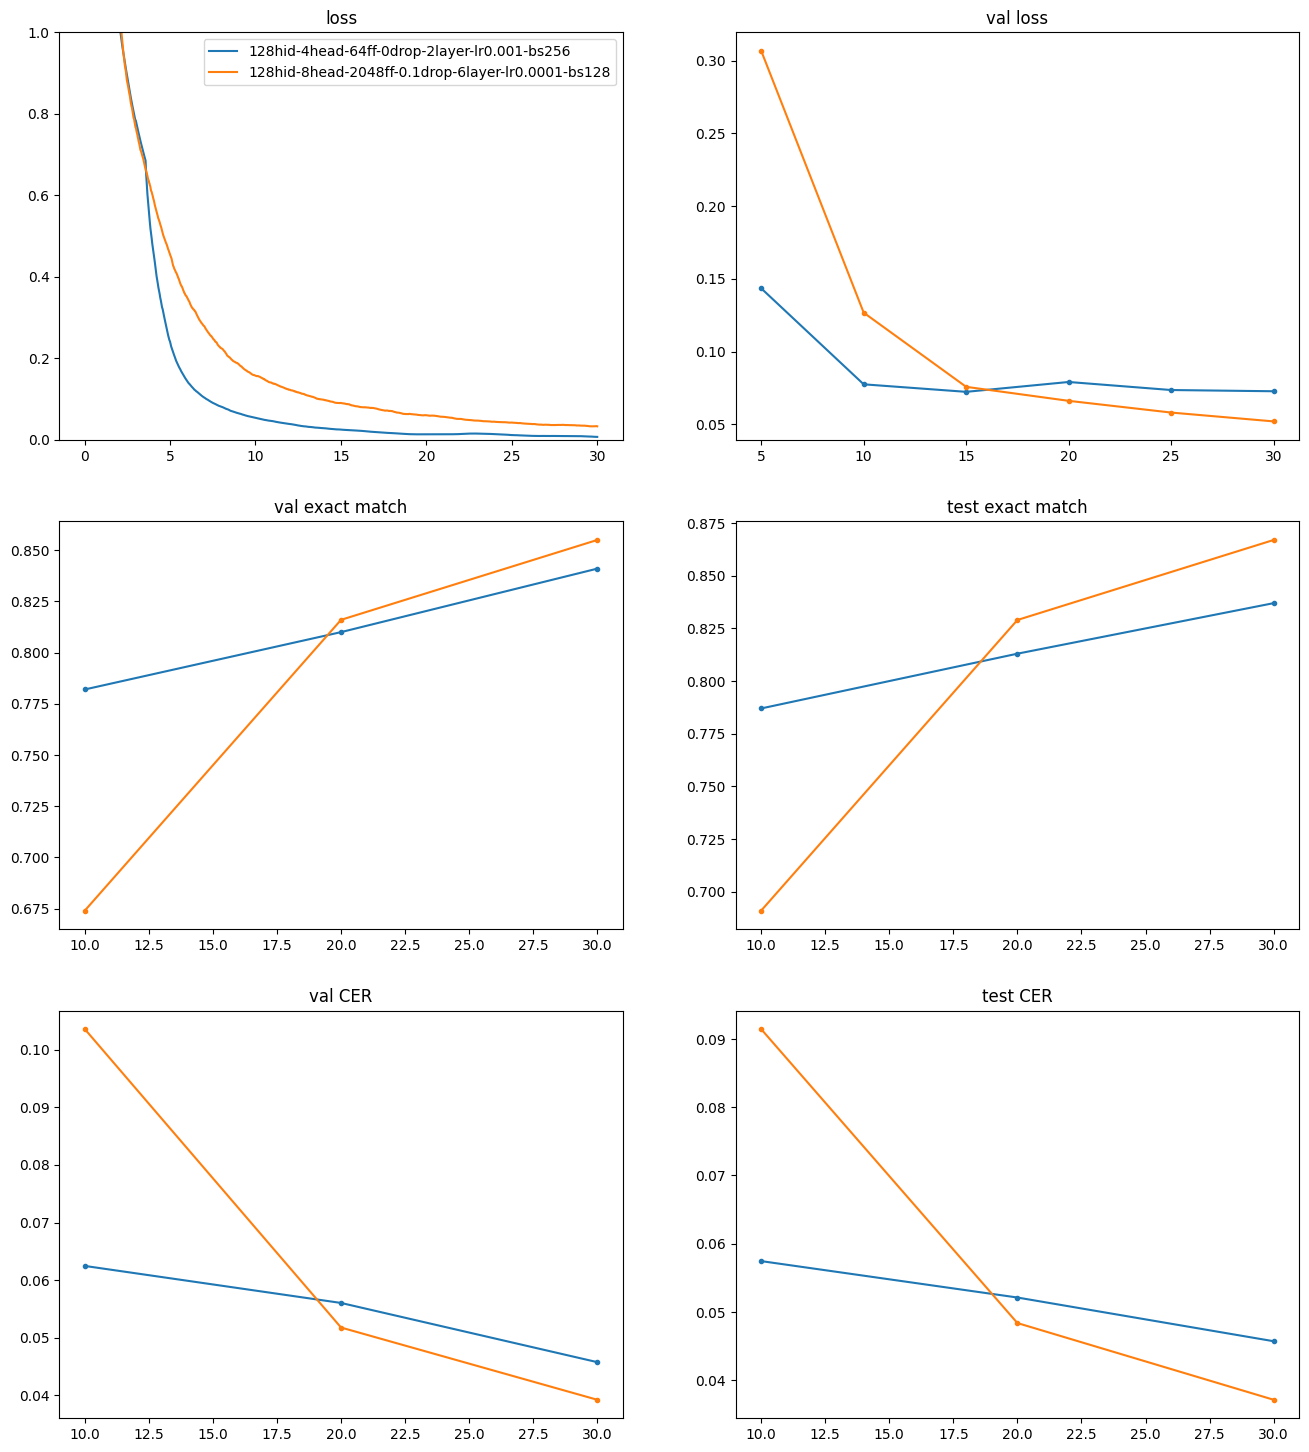

In [129]:
nrows = 3
ncols = 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8*ncols, 6*nrows))
ax = ax.flatten()

def plot(df, key, ax, x='f_ep', **kwargs):
    df = df[df[key].notna()]
    ax.plot(df[x], df[key], **kwargs)

def plot_df(df, label):
    ax[0].set_title('loss')
    plot(df, 'loss', ax=ax[0], label=label)
    ax[0].set_ylim(0, 1)
    ax[0].legend()
    # plot val loss
    ax[1].set_title('val loss')
    plot(df, 'val_loss', ax=ax[1], label='val', marker='.')
    # plot val exact match
    ax[2].set_title('val exact match')
    plot(df, 'val_exact_match', ax=ax[2], marker='.')
    # plot test exact match
    ax[3].set_title('test exact match')
    plot(df, 'test_exact_match', ax=ax[3], marker='.')

    ax[4].set_title('val CER')
    plot(df, 'val_CER', ax=ax[4], marker='.')

    ax[5].set_title('test CER')
    plot(df, 'test_CER', ax=ax[5], marker='.')

# plot each and every run
for key in results.keys():
    plot_df(results[key]['df'], label=key)

In [130]:
# Best model performance

In [131]:
results.keys()

dict_keys(['128hid-4head-64ff-0drop-2layer-lr0.001-bs256', '128hid-8head-2048ff-0.1drop-6layer-lr0.0001-bs128'])

In [132]:
best_model_name = '128hid-8head-2048ff-0.1drop-6layer-lr0.0001-bs128'

In [133]:
# select the model
trainer = results[best_model_name]['trainer']
evaluator = Evaluator(trainer, callbacks=[ProgressCb('predicting')])
# predict
test_loader = DataLoader(test_data, batch_size=64, collate_fn=Collator(tokenizer_th, tokenizer_en))
evaluator.predict(test_loader)

  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


{'exact_match': 0.867, 'BLEU': 0.9006652985209189, 'CER': 0.03713381479631477}

# (7) Prediction

In [134]:
net = results[best_model_name]['net']

In [135]:
test_loader = DataLoader(test_data, batch_size=10, collate_fn=Collator(tokenizer_th, tokenizer_en))
itr = iter(test_loader)

In [136]:
X, Y = next(itr)
Pred = net.predict(X, tokenizer_en)
X = tokenizer_th.decode_batch(X, skip_special_tokens=True)
Y = tokenizer_en.decode_batch(Y, skip_special_tokens=True)

for x, y, pred in zip(X, Y, Pred):
    print('x:', x)
    print('y:', y)
    print('pred:', pred)
    print('---')

x: ศักดา
y: sakda
pred: sakda
---
x: สุภาพ
y: suphap
pred: suphap
---
x: ประนอม
y: pranom
pred: pranom
---
x: ชาญวุฒิ
y: chanwutthi
pred: chanwutthi
---
x: เลิศศักดิ์
y: loetsak
pred: loetsak
---
x: ตูวันอิบราฮีม
y: tuwanibarahim
pred: tuwaniphimot
---
x: เตชิษฐ์
y: tachoet
pred: techit
---
x: นิคม
y: nikhom
pred: nikhom
---
x: ประยงค์
y: prayong
pred: prayong
---
x: บุญธรรม
y: buntham
pred: buntham
---


# (8) Test your name

In [137]:
th_name = 'อิทธิกร'
x = [tokenizer_th.encode(th_name)] # batchify
x = torch.LongTensor(x) # convert to tensor
print(net.predict(x, tokenizer_en)) # predict

['itthikon']


# Your job

## Why cross-entroy and exact match might not be good metrics for this task?

- Cross entropy is too sensitive to minor errors and exact match is too strict

## In your opinion, what is the "right" metric for this task?
- CER (Character Error Rate) measure the percentage of characters that are incorrect in predicted translation compared to referenced translation

- Propose your own metric and **justify your answer**

## What is your recipe for training this network?

- There are some hyperparameters worth tuning:
    - `n_head`
    - `n_layer`
    - `n_ff`
    - `dropout`
    - `n_ep` = how long to run
    - `lr` = learning rate
    - `bs` = batch size
- Finally, conclude your best results, with **your own metric**.

**Write this as a report in PDF.**
Include the screeenshots

- Result of the best model.
- Implementation of your metric

